In [1]:
import pandas as pd

df = pd.read_csv("../Pdata/commodity_close_prices", parse_dates = True, index_col = 0)
print(df)

                 CPER         USO        SLV         GLD
Date                                                    
2011-11-15  25.180000  307.440002  33.660000  173.360001
2011-11-16  25.190001  314.720001  32.820000  171.509995
2011-11-17  25.190001  305.839996  30.639999  167.100006
2011-11-18  24.430000  302.559998  31.400000  167.619995
2011-11-21  23.690001  300.720001  30.760000  163.500000
...               ...         ...        ...         ...
2020-12-24  22.010000   32.919998  23.959999  176.350006
2020-12-28  22.190001   32.590000  24.430000  175.710007
2020-12-29  21.980000   32.779999  24.389999  176.350006
2020-12-30  21.950001   32.910000  24.760000  177.699997
2020-12-31  21.730000   33.009998  24.570000  178.360001

[2297 rows x 4 columns]


Here we model different correlations

we attempt 3 approaches

constant correlation

DCC

Stochastic correlation under the OU process as is Teng, Ehrhardt and Gunther (2016)

For the purposes of cross-examination we deal with just SLV and GLD to start    

correlation follows a simple formula

rho = covar(x,y)/sig(x)sig(y)

we use pearsons correlaton coefficeint as well as spearmans (non gaussian dist with assumption the variables are not linearly dependent)

Note: this applies the correlation over the entire window of the observed data

In [2]:
from scipy.stats import pearsonr
corr_p, _ = pearsonr(df.SLV, df.GLD)
print('Pearsons correlation: %.3f' % corr_p)

Pearsons correlation: 0.753


In [3]:
from scipy.stats import spearmanr
corr_s, _ = spearmanr(df.SLV, df.GLD)
print('Spearman correlation: %.3f' % corr_s)

Spearman correlation: 0.713


Now we examine rolling correlations and plot them

In [4]:
win_30 = df.SLV.rolling(30).corr(df.GLD).dropna()
win_30.plot()

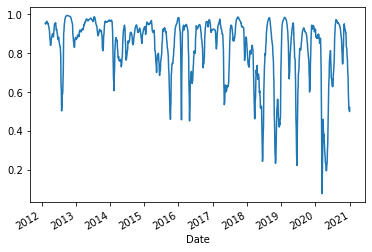

In [5]:
win_60 = df.SLV.rolling(60).corr(df.GLD).dropna()
win_60.plot()


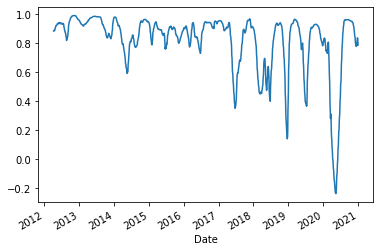

In [6]:
win_100 = df.SLV.rolling(100).corr(df.GLD).dropna()
win_100.plot()

We note that as we increase the window size, the curves become smoother and we extract a less noisy signal

We can extract the DCC via a GARCH model

Extracting the step-wise covariance matrix and solving for the correlations at each time step.
We save these and plot them 


In [106]:
# we need to calculate the log-returns between our variables first
import numpy as np
import datetime as dt
from dcc import DCC

slv_l_ret = np.log(df.SLV/df.SLV.shift(1))*100
gld_l_ret = np.log(df.GLD/df.GLD.shift(1))*100
uso_l_ret = np.log(df.USO/df.USO.shift(1))*100
df_l_ret = pd.DataFrame([slv_l_ret, gld_l_ret, uso_l_ret]).transpose()
df_l_ret = df_l_ret.dropna()

rt = df_l_ret[['SLV', 'GLD']]
window = 30
n_days = 1
i = DCC()
sample = rt[1000:]
series = i.conditional_corr(sample, window, n_days, 't')


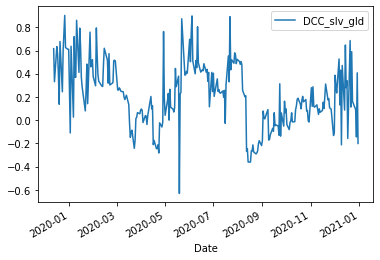

In [110]:
# attach an index for the dates on the X axis
ind = sample[window:]
s = pd.DataFrame(list(series), columns = ['DCC_slv_gld'], index = ind.index)
s.plot()

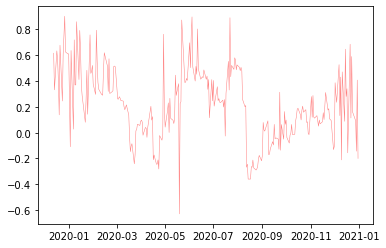

In [111]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(s)
# plotting the empirical density function of the dynamic conditional correlation model

Next we attempt to model the stochastic correlation of two correlated bronwian motions.

This endeavour is a little bit tricky and involves more steps, maths and coffee. The code for this function will be included in the file; stoch_corr.py, within it the class ModifiedOU is called for calibration and estimation of the stochastic correlation under two correlated Brownian Motions.

In short it involves fitting a transition density function to the historical correlations